Install NumPyro by running:
`$ pip install --upgrade numpyro`

In [1]:
from functools import partial

# Import regular numpy in additional to JAX's
import numpy
import scipy.stats

import matplotlib.pyplot as plt
%matplotlib inline

%run helpers.ipynb

In [2]:
# Compute on a CPU using 2 cores
numpyro.set_platform("cpu")
numpyro.set_host_device_count(2)

# Make plots larger by default
plt.rc("figure", dpi=100)

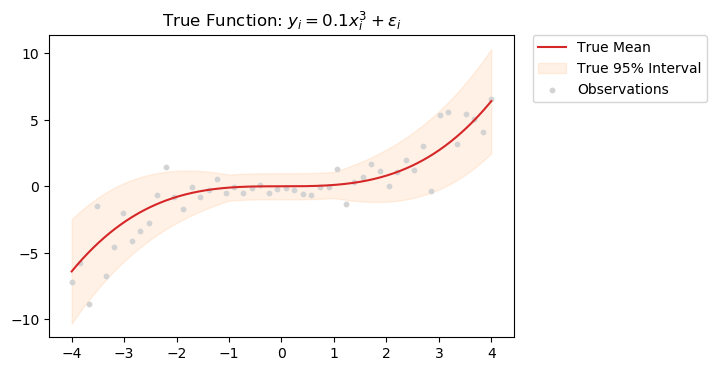

In [3]:
# Define the true function and generate observations
def func(x):
    std = np.abs(x) * 0.5
    std = np.where(std < 0.5, 0.5, std)
    return scipy.stats.norm(loc=0.1 * x ** 3, scale=std)


func.latex = r"$y_i = 0.1x_i^3 + \varepsilon_i$"

data_points = [
    {"n_points": 50, "xlim": [-4, 4]},
]
df = generate_data(func, points=data_points, seed=2)

# Plot the data
plot_true_function(func, df, title=f"True Function: {func.latex}")

In [4]:
# Observations
X = df[["x"]].values
Y = df[["y"]].values
X_test = numpy.linspace(X.min(), X.max(), num=1000)[:, np.newaxis]

# Number of hidden layers
hidden = 2
# Width of hidden layers
width = 10
# Standard deviation of the prior
sigma = 1.5
# Standard deviation of the likelihood
noise = 0.5

# Instantiate the model
model = partial(feedforward, X=X, Y=Y, width=width, hidden=hidden, sigma=sigma, noise=noise)

In [5]:
%%time
# Sampler parameters
num_chains = 2
num_samples = 2000
num_warmup = 2000

# Run the No-U-Turn sampler. Note: sampling more than one chain in parallel doesn't show a progress bar.
mcmc = sample(model, num_samples, num_warmup, num_chains, seed=0, summary=True)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b0[0,0]      0.01      3.11      0.02     -5.01      5.36    227.00      1.01
   b0[0,1]     -0.06      3.30     -0.03     -5.42      5.69    204.14      1.00
   b0[0,2]     -0.12      3.10     -0.01     -5.46      4.76    297.39      1.00
   b0[0,3]     -0.12      3.10     -0.32     -4.85      5.33    236.05      1.01
   b0[0,4]      0.25      3.11      0.27     -4.87      5.46    249.87      1.00
   b0[0,5]      0.27      3.21      0.27     -5.13      5.48    220.40      1.02
   b0[0,6]     -0.25      3.32     -0.25     -5.61      5.38    166.84      1.01
   b0[0,7]     -0.18      3.30     -0.29     -5.44      5.50    182.60      1.00
   b0[0,8]      0.02      3.01      0.03     -5.21      4.83    254.60      1.01
   b0[0,9]     -0.02      3.33     -0.00     -5.63      5.41    207.32      1.00
   b1[0,0]     -0.01      1.45     -0.02     -2.51      2.26   1551.26      1.00
   b1[0,1]     -0.04      1

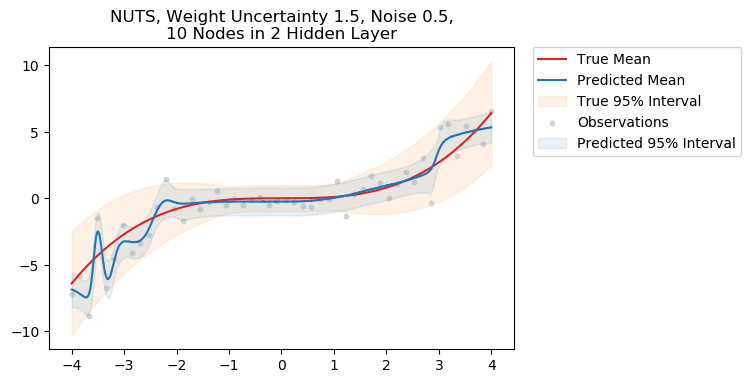

In [6]:
# Generate the posterior predictive and plot the results
posterior_predictive = simulate_posterior_predictive(model, mcmc, X_test, seed=1)
plot_posterior_predictive(
    X_test,
    posterior_predictive,
    func=func,
    df=df,
    title=f"NUTS, Weight Uncertainty {sigma}, Noise {noise},\n" f"{width} Nodes in {hidden} Hidden Layer",
)